In [16]:
from pathlib import Path

import numpy as np
import SimpleITK as sitk
import torch

from fireants.io.image import Image as FAImage, BatchedImages
from fireants.registration.affine import AffineRegistration

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [17]:
# File paths (adjust if you want to try other stacks)
FIXED_PATH = Path('/mnt/nas_jlarsch/johannes/testIn/average_2p_noRot_flip_8b.nrrd')
MOVING_PATH = Path('/mnt/nas_jlarsch/johannes/testIn/L395_f10_anatomy_00002_8b.nrrd')

# Outputs land in a dedicated affine-only folder so we can iterate quickly
OUTPUT_DIR = Path('/mnt/nas_jlarsch/Johannes/testOutput/fireants/affineOnly').resolve()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f'Fixed:  {FIXED_PATH}')
print(f'Moving: {MOVING_PATH}')
print(f'Outputs will be written to: {OUTPUT_DIR}')

Fixed:  /mnt/nas_jlarsch/johannes/testIn/average_2p_noRot_flip_8b.nrrd
Moving: /mnt/nas_jlarsch/johannes/testIn/L395_f10_anatomy_00002_8b.nrrd
Outputs will be written to: /mnt/nas_jlarsch/Johannes/testOutput/fireants/affineOnly


## Quick geometry sanity check
Peek at voxel spacing, orientation, and extent before any registration tweaks.

In [18]:
def describe_image(path):
    img = sitk.ReadImage(str(path))
    size = img.GetSize()
    spacing = img.GetSpacing()
    direction = img.GetDirection()
    origin = img.GetOrigin()
    extent_mm = tuple(round(s * sp, 3) for s, sp in zip(size, spacing))
    return {
        'path': str(path),
        'size': size,
        'spacing': spacing,
        'direction': direction,
        'origin': origin,
        'extent_mm': extent_mm,
        'dtype': img.GetPixelIDTypeAsString(),
        'components': img.GetNumberOfComponentsPerPixel(),
    }

metadata_summary = []
for label, path in [('fixed', FIXED_PATH), ('moving', MOVING_PATH)]:
    info = describe_image(path)
    info['label'] = label
    metadata_summary.append(info)
    print(f"{label.upper()} -> size {info['size']}, spacing {info['spacing']}, extent (mm) {info['extent_mm']}")
    print(f"             direction {info['direction']}")
    print(f"             origin    {info['origin']}, dtype {info['dtype']}, components {info['components']}")
    print()

metadata_summary

FIXED -> size (512, 512, 183), spacing (1.0484, 1.0484, 1.0), extent (mm) (536.781, 536.781, 183.0)
             direction (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
             origin    (0.0, 0.0, 0.0), dtype 8-bit unsigned integer, components 1

MOVING -> size (512, 512, 206), spacing (1.048361882567406, 1.048361882567406, 1.0), extent (mm) (536.761, 536.761, 206.0)
             direction (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
             origin    (0.0, 0.0, 0.0), dtype 8-bit unsigned integer, components 1

MOVING -> size (512, 512, 206), spacing (1.048361882567406, 1.048361882567406, 1.0), extent (mm) (536.761, 536.761, 206.0)
             direction (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
             origin    (0.0, 0.0, 0.0), dtype 8-bit unsigned integer, components 1



[{'path': '/mnt/nas_jlarsch/johannes/testIn/average_2p_noRot_flip_8b.nrrd',
  'size': (512, 512, 183),
  'spacing': (1.0484, 1.0484, 1.0),
  'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
  'origin': (0.0, 0.0, 0.0),
  'extent_mm': (536.781, 536.781, 183.0),
  'dtype': '8-bit unsigned integer',
  'components': 1,
  'label': 'fixed'},
 {'path': '/mnt/nas_jlarsch/johannes/testIn/L395_f10_anatomy_00002_8b.nrrd',
  'size': (512, 512, 206),
  'spacing': (1.048361882567406, 1.048361882567406, 1.0),
  'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
  'origin': (0.0, 0.0, 0.0),
  'extent_mm': (536.761, 536.761, 206.0),
  'dtype': '8-bit unsigned integer',
  'components': 1,
  'label': 'moving'}]

## Preprocessing toggles
We mirror the main notebook but focus purely on affine experiments. Histogram matching and a coarse mask are optional and can be toggled per experiment.

In [19]:
RESAMPLE_MOVING_TO_FIXED = True
INTENSITY_NORMALIZE = True
APPLY_HISTOGRAM_MATCHING = True
GENERATE_MASKS = False
INITIAL_ALIGNMENT_MODE = 'moments'  # options: 'geometry', 'moments'
AUTO_CENTER_CORRECTION = True
CENTROID_SHIFT_THRESHOLD_MM = 0.5

fixed_sitk = sitk.Cast(sitk.ReadImage(str(FIXED_PATH)), sitk.sitkFloat32)
moving_sitk = sitk.Cast(sitk.ReadImage(str(MOVING_PATH)), sitk.sitkFloat32)

def compute_intensity_centroid(image: sitk.Image) -> np.ndarray:
    array = sitk.GetArrayFromImage(image).astype(np.float64)
    total = array.sum()
    if total <= 0:
        center_index = np.asarray(image.GetSize(), dtype=np.float64) / 2.0
        return np.array(image.TransformContinuousIndexToPhysicalPoint(tuple(center_index)))
    indices = np.indices(array.shape, dtype=np.float64)
    centroid_zyx = np.array([(indices[i] * array).sum() for i in range(3)]) / total
    centroid_xyz = np.array([centroid_zyx[2], centroid_zyx[1], centroid_zyx[0]])
    spacing = np.asarray(image.GetSpacing(), dtype=np.float64)
    direction = np.asarray(image.GetDirection(), dtype=np.float64).reshape(3, 3)
    origin = np.asarray(image.GetOrigin(), dtype=np.float64)
    centroid_mm = origin + direction @ (centroid_xyz * spacing)
    return centroid_mm

alignment_mode_map = {
    'geometry': sitk.CenteredTransformInitializerFilter.GEOMETRY,
    'moments': sitk.CenteredTransformInitializerFilter.MOMENTS,
}
initializer_method = alignment_mode_map.get(INITIAL_ALIGNMENT_MODE.lower(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
initial_centering = sitk.CenteredTransformInitializer(
    fixed_sitk,
    moving_sitk,
    sitk.AffineTransform(3),
    initializer_method
)
method_name = 'MOMENTS' if initializer_method == sitk.CenteredTransformInitializerFilter.MOMENTS else 'GEOMETRY'
print(f'Initial alignment mode: {method_name}')

initial_affine_transform = sitk.AffineTransform(initial_centering)
if RESAMPLE_MOVING_TO_FIXED:
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_sitk)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0.0)
    resampler.SetTransform(initial_affine_transform)
    moving_resampled_sitk = resampler.Execute(moving_sitk)
else:
    moving_resampled_sitk = moving_sitk
applied_centroid_offset = np.zeros(3, dtype=np.float64)

if AUTO_CENTER_CORRECTION and RESAMPLE_MOVING_TO_FIXED:
    fixed_centroid_mm = compute_intensity_centroid(fixed_sitk)
    moving_centroid_mm = compute_intensity_centroid(moving_resampled_sitk)
    centroid_offset = fixed_centroid_mm - moving_centroid_mm
    threshold_mm = max(CENTROID_SHIFT_THRESHOLD_MM, 0.25 * min(fixed_sitk.GetSpacing()))
    if np.linalg.norm(centroid_offset) > threshold_mm:
        initial_affine_transform.Translate(tuple(centroid_offset.tolist()))
        resampler.SetTransform(initial_affine_transform)
        moving_resampled_sitk = resampler.Execute(moving_sitk)
        applied_centroid_offset = centroid_offset
        print(f'Applied centroid correction (mm): {centroid_offset}')
    else:
        print('Centroid correction skipped; offset below threshold.')

moving_preprocessed_sitk = moving_resampled_sitk

if APPLY_HISTOGRAM_MATCHING:
    matcher = sitk.HistogramMatchingImageFilter()
    matcher.SetNumberOfHistogramLevels(256)
    matcher.SetNumberOfMatchPoints(32)
    matcher.SetThresholdAtMeanIntensity(True)
    moving_preprocessed_sitk = matcher.Execute(moving_preprocessed_sitk, fixed_sitk)

if INTENSITY_NORMALIZE:
    fixed_preprocessed_sitk = sitk.RescaleIntensity(fixed_sitk, 0.0, 1.0)
    moving_preprocessed_sitk = sitk.RescaleIntensity(moving_preprocessed_sitk, 0.0, 1.0)
else:
    fixed_preprocessed_sitk = fixed_sitk

print('Fixed size:', fixed_preprocessed_sitk.GetSize(), 'spacing:', fixed_preprocessed_sitk.GetSpacing())
print('Moving size:', moving_preprocessed_sitk.GetSize(), 'spacing:', moving_preprocessed_sitk.GetSpacing())

fixed_mask_sitk = None
moving_mask_sitk = None
if GENERATE_MASKS:
    mask_filter = sitk.OtsuThresholdImageFilter()
    mask_filter.SetInsideValue(0)
    mask_filter.SetOutsideValue(1)
    fixed_mask_sitk = sitk.Cast(mask_filter.Execute(fixed_preprocessed_sitk), sitk.sitkUInt8)
    moving_mask_sitk = sitk.Cast(mask_filter.Execute(moving_preprocessed_sitk), sitk.sitkUInt8)
    print('Generated coarse foreground masks via Otsu thresholding.')

centroid_offset_mm = applied_centroid_offset.astype(np.float32)
initial_centering = initial_affine_transform

Initial alignment mode: MOMENTS
Applied centroid correction (mm): [10.17345678 24.41957549 -6.68983969]
Applied centroid correction (mm): [10.17345678 24.41957549 -6.68983969]
Fixed size: (512, 512, 183) spacing: (1.0484, 1.0484, 1.0)
Moving size: (512, 512, 183) spacing: (1.0484, 1.0484, 1.0)
Fixed size: (512, 512, 183) spacing: (1.0484, 1.0484, 1.0)
Moving size: (512, 512, 183) spacing: (1.0484, 1.0484, 1.0)


In [20]:
fixed_fa_image = FAImage(fixed_preprocessed_sitk, device=device, dtype=torch.float32)
moving_fa_image = FAImage(moving_preprocessed_sitk, device=device, dtype=torch.float32)

fixed_batch = BatchedImages(fixed_fa_image)
moving_batch = BatchedImages(moving_fa_image)

fixed_mask_fa = None
moving_mask_fa = None
if GENERATE_MASKS and fixed_mask_sitk is not None and moving_mask_sitk is not None:
    fixed_mask_fa = FAImage(fixed_mask_sitk, device=device, dtype=torch.float32)
    moving_mask_fa = FAImage(moving_mask_sitk, device=device, dtype=torch.float32)

print('Fixed FireANTs tensor:', tuple(fixed_fa_image.array.shape))
print('Moving FireANTs tensor:', tuple(moving_fa_image.array.shape))

Fixed FireANTs tensor: (1, 1, 183, 512, 512)
Moving FireANTs tensor: (1, 1, 183, 512, 512)


In [21]:
def sitk_affine_to_homogeneous(transform: sitk.Transform) -> np.ndarray:
    affine = sitk.AffineTransform(transform)
    matrix = np.array(affine.GetMatrix()).reshape(3, 3)
    translation = np.array(affine.GetTranslation()).reshape(3, 1)
    homogeneous = np.eye(4, dtype=np.float32)
    homogeneous[:3, :3] = matrix
    homogeneous[:3, 3:] = translation
    return homogeneous

initial_affine_np = sitk_affine_to_homogeneous(initial_centering)
initial_affine_tensor = torch.from_numpy(initial_affine_np).unsqueeze(0).to(device=device, dtype=torch.float32)
print('Initial centering affine (homogeneous):\n', initial_affine_np)

initial_linear = initial_affine_np[:3, :3]
initial_translation = initial_affine_np[:3, 3]
initial_singular_values = np.linalg.svd(initial_linear, compute_uv=False)
initial_warp_array = sitk.GetArrayFromImage(moving_preprocessed_sitk).astype(np.float32)
initial_stage_warp_tensor = torch.from_numpy(initial_warp_array).unsqueeze(0)
INITIAL_STAGE_TEMPLATE = {
    'index': 0,
    'label': f'initializer:{method_name.lower()}',
    'config': {
        'initializer_mode': method_name.lower(),
        'resample_moving': RESAMPLE_MOVING_TO_FIXED,
        'histogram_matching': APPLY_HISTOGRAM_MATCHING,
        'intensity_normalize': INTENSITY_NORMALIZE,
        'auto_center_correction': AUTO_CENTER_CORRECTION,
    },
    'affine_matrix': initial_affine_np.copy(),
    'warp_tensor': initial_stage_warp_tensor,
    'summary': {
        'linear': initial_linear.copy(),
        'translation': initial_translation.copy(),
        'singular_values': initial_singular_values.copy(),
        'centroid_offset_mm': centroid_offset_mm.copy(),
    },
}

affine_experiments = {
    'moments_two_stage': {
        'description': 'Moments initializer with a coarse-to-fine two-stage affine refinement tuned for stability',
        'stages': [
            {
                'shrink_factors': [6, 3, 2],
                'iterations': [120, 90, 60],
                'optimizer': 'Adam',
                'optimizer_lr': 0.003,
                'cc_kernel_size': 7,
                'use_initial_affine': False,
                'use_masks': False,
                'around_center': True,
                'tolerance': 1e-4,
                'max_tolerance_iters': 30,
            },
            {
                'shrink_factors': [2, 1],
                'iterations': [140, 110],
                'optimizer': 'Adam',
                'optimizer_lr': 0.0012,
                'cc_kernel_size': 5,
                'use_initial_affine': False,
                'use_masks': False,
                'around_center': True,
                'tolerance': 5e-5,
                'max_tolerance_iters': 40,
            },
        ],
    },
    'moments_single_refine': {
        'description': 'Moments initializer with a single multi-resolution affine refinement',
        'stages': [
            {
                'shrink_factors': [4, 2, 1],
                'iterations': [140, 100, 80],
                'optimizer': 'Adam',
                'optimizer_lr': 0.0012,
                'cc_kernel_size': 5,
                'use_initial_affine': False,
                'use_masks': False,
                'around_center': True,
                'tolerance': 5e-5,
                'max_tolerance_iters': 40,
            },
        ],
    },
    'legacy_translation_anchor': {
        'description': 'Original translation-anchored schedule retained for comparison',
        'stages': [
            {
                'shrink_factors': [16, 12, 8],
                'iterations': [150, 120, 90],
                'optimizer': 'Adam',
                'optimizer_lr': 0.02,
                'cc_kernel_size': 9,
                'use_initial_affine': False,
                'use_masks': False,
                'around_center': False,
            },
            {
                'shrink_factors': [8, 6, 4],
                'iterations': [120, 90, 60],
                'optimizer': 'Adam',
                'optimizer_lr': 0.01,
                'cc_kernel_size': 7,
                'use_initial_affine': False,
                'use_masks': False,
                'around_center': False,
            },
            {
                'shrink_factors': [4, 3, 2],
                'iterations': [120, 120, 90],
                'optimizer': 'Adam',
                'optimizer_lr': 0.003,
                'cc_kernel_size': 5,
                'use_initial_affine': False,
                'use_masks': False,
                'around_center': True,
                'tolerance': 1e-4,
                'max_tolerance_iters': 30,
            },
            {
                'shrink_factors': [2, 1],
                'iterations': [160, 120],
                'optimizer': 'Adam',
                'optimizer_lr': 0.0015,
                'cc_kernel_size': 3,
                'use_initial_affine': False,
                'use_masks': False,
                'around_center': True,
                'tolerance': 5e-5,
                'max_tolerance_iters': 40,
            },
            {
                'shrink_factors': [1],
                'iterations': [260],
                'optimizer': 'Adam',
                'optimizer_lr': 0.0003,
                'cc_kernel_size': 3,
                'use_initial_affine': False,
                'use_masks': False,
                'around_center': True,
                'tolerance': 2e-5,
                'max_tolerance_iters': 60,
            },
        ],
    },
}

RUN_EXPERIMENTS = ['moments_two_stage']
SAVE_STAGE_OUTPUTS = True
print('Configured affine experiments:', RUN_EXPERIMENTS)

def instantiate_affine(stage_cfg, fixed_mask=None, moving_mask=None):
    affine_kwargs = {
        'optimizer': stage_cfg['optimizer'],
        'optimizer_lr': stage_cfg['optimizer_lr'],
        'cc_kernel_size': stage_cfg.get('cc_kernel_size', 5),
    }
    if fixed_mask is not None and moving_mask is not None:
        affine_kwargs['fixed_mask'] = fixed_mask
        affine_kwargs['moving_mask'] = moving_mask
    optional_forward = (
        'loss_type',
        'around_center',
        'tolerance',
        'max_tolerance_iters',
        'optimizer_params',
        'loss_params',
    )
    for key in optional_forward:
        if key in stage_cfg:
            affine_kwargs[key] = stage_cfg[key]
    def attempt_create(kwargs):
        return AffineRegistration(stage_cfg['shrink_factors'], stage_cfg['iterations'], fixed_batch, moving_batch, **kwargs)
    try:
        return attempt_create(affine_kwargs)
    except TypeError as exc:
        unsupported = []
        for key in list(optional_forward):
            if key in affine_kwargs and f"{key}" in str(exc):
                unsupported.append(key)
        if unsupported:
            for key in unsupported:
                affine_kwargs.pop(key, None)
            print(f"Warning: stage parameter(s) {unsupported} not supported by this FireANTs build; retrying without them.")
            return attempt_create(affine_kwargs)
        if 'fixed_mask' in affine_kwargs or 'moving_mask' in affine_kwargs:
            affine_kwargs.pop('fixed_mask', None)
            affine_kwargs.pop('moving_mask', None)
            print('Warning: mask inputs not supported by this FireANTs version; retrying without masks.')
            return attempt_create(affine_kwargs)
        raise exc

def run_affine_stage(stage_cfg, init_affine_tensor):
    fixed_mask = globals().get('fixed_mask_fa')
    moving_mask = globals().get('moving_mask_fa')
    use_masks = stage_cfg.get('use_masks', False) and fixed_mask is not None and moving_mask is not None
    if stage_cfg.get('use_initial_affine', False):
        print('Initial affine seeding requested but not supported by this FireANTs build; running without it.')
    affine = instantiate_affine(
        stage_cfg,
        fixed_mask=fixed_mask if use_masks else None,
        moving_mask=moving_mask if use_masks else None
    )
    affine.optimize()
    warp = affine.evaluate(fixed_batch, moving_batch)
    return affine, warp

def summarize_affine_matrix(affine_obj, label):
    matrix = affine_obj.get_affine_matrix(homogenous=False)[0].detach().cpu().numpy()
    linear = matrix[:, :3]
    translation = matrix[:, 3]
    singular_values = np.linalg.svd(linear, compute_uv=False)
    print(f'[{label}] linear:\n{linear}')
    print(f'[{label}] translation: {translation}')
    print(f'[{label}] singular values: {singular_values}')
    return linear, translation, singular_values

Initial centering affine (homogeneous):
 [[  1.         0.         0.       -14.413177]
 [  0.         1.         0.       -46.659508]
 [  0.         0.         1.        20.777445]
 [  0.         0.         0.         1.      ]]
Configured affine experiments: ['moments_two_stage']
Configured affine experiments: ['moments_two_stage']


In [22]:
if 'RUN_EXPERIMENTS' not in globals():
    RUN_EXPERIMENTS = list(affine_experiments.keys())
    print("RUN_EXPERIMENTS not defined earlier; defaulting to all available experiments.")

if 'SAVE_STAGE_OUTPUTS' not in globals():
    SAVE_STAGE_OUTPUTS = False

results = []
for exp_name in RUN_EXPERIMENTS:
    cfg = affine_experiments[exp_name]
    desc = cfg.get('description', '')
    print('-' * 72)
    print(f'Running experiment: {exp_name} -> {desc}')
    stages = cfg.get('stages')
    stage_configs = stages if stages is not None else [cfg]
    init_tensor = initial_affine_tensor
    stage_records = []
    if 'INITIAL_STAGE_TEMPLATE' in globals() and INITIAL_STAGE_TEMPLATE is not None:
        template = INITIAL_STAGE_TEMPLATE
        centroid_summary = template['summary'].get('centroid_offset_mm')
        if centroid_summary is not None:
            centroid_summary = centroid_summary.copy()
        stage0_summary = {
            'linear': template['summary']['linear'].copy(),
            'translation': template['summary']['translation'].copy(),
            'singular_values': template['summary']['singular_values'].copy(),
            'centroid_offset_mm': centroid_summary,
        }
        stage0 = {
            'index': template['index'],
            'label': template['label'],
            'config': dict(template['config']),
            'affine': None,
            'affine_matrix': template['affine_matrix'].copy(),
            'warp': template['warp_tensor'].detach().cpu() if SAVE_STAGE_OUTPUTS else None,
            'summary': stage0_summary,
        }
        if SAVE_STAGE_OUTPUTS:
            stage_records.append(stage0)
        else:
            stage_records.append({k: v for k, v in stage0.items() if k != 'warp'})
    last_affine = None
    last_warp_cpu = None
    for stage_idx, stage_cfg in enumerate(stage_configs, start=1):
        affine_obj, warp = run_affine_stage(stage_cfg, init_tensor)
        label = f'{exp_name}:stage{stage_idx}'
        linear, translation, singular_values = summarize_affine_matrix(affine_obj, label)
        warp_cpu = warp.detach().cpu()
        affine_matrix_h = affine_obj.get_affine_matrix(homogenous=True)[0].detach().cpu().numpy()
        stage_record = {
            'index': stage_idx,
            'label': label,
            'config': {k: v for k, v in stage_cfg.items()},
            'affine': affine_obj,
            'affine_matrix': affine_matrix_h,
            'warp': warp_cpu if SAVE_STAGE_OUTPUTS else None,
            'summary': {
                'linear': linear,
                'translation': translation,
                'singular_values': singular_values,
                'centroid_offset_mm': None,
            },
        }
        if SAVE_STAGE_OUTPUTS:
            stage_records.append(stage_record)
        else:
            stage_records.append({k: v for k, v in stage_record.items() if k != 'warp'})
        last_affine = affine_obj
        last_warp_cpu = warp_cpu
        init_tensor = affine_obj.get_affine_matrix(homogenous=True)
    results.append({
        'name': exp_name,
        'description': desc,
        'stages': stage_records,
        'affine': last_affine,
        'warp': last_warp_cpu,
    })

print('Completed experiments:', [r['name'] for r in results])

INFO:fireants.registration.abstract:Registration of type AffineRegistration initialized with dtype torch.float32


------------------------------------------------------------------------
Running experiment: moments_two_stage -> Moments initializer with a coarse-to-fine two-stage affine refinement tuned for stability


scale: 6, iter: 119/120, loss: -0.857269: 100%|██████████| 120/120 [00:01<00:00, 104.21it/s]

scale: 3, iter: 89/90, loss: -0.879958: 100%|██████████| 90/90 [00:02<00:00, 33.17it/s]

scale: 2, iter: 59/60, loss: -0.899420: 100%|██████████| 60/60 [00:05<00:00, 11.16it/s]



[moments_two_stage:stage1] linear:
[[ 1.0374563  -0.18061441 -0.06269476]
 [-0.19339314  1.0325034   0.22036329]
 [ 0.06125044 -0.01312512  1.0721138 ]]
[moments_two_stage:stage1] translation: [ 43.56839   22.928802 -19.084442]
[moments_two_stage:stage1] singular values: [1.261323  1.0693556 0.8269139]


INFO:fireants.registration.abstract:Registration of type AffineRegistration initialized with dtype torch.float32
scale: 1, iter: 109/110, loss: -0.947557: 100%|██████████| 110/110 [00:59<00:00,  1.84it/s]



[moments_two_stage:stage2] linear:
[[ 1.072562    0.01819352  0.01997823]
 [ 0.16893458  1.156827    0.05431933]
 [-0.20276022  0.11215375  1.2311915 ]]
[moments_two_stage:stage2] translation: [-26.083649 -92.11691    3.14328 ]
[moments_two_stage:stage2] singular values: [1.2937297  1.217983   0.96600264]
Completed experiments: ['moments_two_stage']
Completed experiments: ['moments_two_stage']


## Export and inspection helpers

In [23]:
import re

def tensor_to_sitk(tensor, reference):
    array = tensor.squeeze().detach().cpu().numpy().astype('float32')
    image = sitk.GetImageFromArray(array)
    image.CopyInformation(reference.itk_image)
    return image

_stage_filename_pattern = re.compile(r'[^a-zA-Z0-9]+')

def sanitize_stage_label(label: str) -> str:
    sanitized = _stage_filename_pattern.sub('_', label).strip('_')
    return sanitized or 'stage'

for record in results:
    name = record['name']
    affine_obj = record['affine']
    warp_tensor = record['warp']
    experiment_dir = OUTPUT_DIR / name
    stage_dir = experiment_dir / 'stages'
    stage_dir.mkdir(parents=True, exist_ok=True)

    if affine_obj is not None and warp_tensor is not None:
        out_warp = tensor_to_sitk(warp_tensor, fixed_fa_image)
        out_path = OUTPUT_DIR / f'moving_{name}_affine_warped.nrrd'
        sitk.WriteImage(out_warp, str(out_path))
        affine_transform_path = OUTPUT_DIR / f'{name}_affine_transform.mat'
        affine_obj.save_as_ants_transforms(str(affine_transform_path))
        print(f'Saved warped volume -> {out_path}')
        print(f'Saved affine transform -> {affine_transform_path}')

    for stage in record['stages']:
        stage_warp = stage.get('warp')
        if stage_warp is None:
            continue
        stage_index = stage.get('index', -1)
        stage_label = stage.get('label', f'stage_{stage_index}')
        safe_label = sanitize_stage_label(stage_label)
        warp_image = tensor_to_sitk(stage_warp, fixed_fa_image)
        stage_warp_path = stage_dir / f'stage_{stage_index:02d}_{safe_label}.nrrd'
        sitk.WriteImage(warp_image, str(stage_warp_path))
        print(f'  Stage {stage_index} warp saved -> {stage_warp_path}')

        affine_matrix = stage.get('affine_matrix')
        if affine_matrix is not None:
            matrix_path = stage_dir / f'stage_{stage_index:02d}_{safe_label}_affine.npy'
            np.save(matrix_path, affine_matrix)
        stage_affine_obj = stage.get('affine')
        if stage_affine_obj is not None:
            stage_transform_path = stage_dir / f'stage_{stage_index:02d}_{safe_label}.mat'
            stage_affine_obj.save_as_ants_transforms(str(stage_transform_path))


INFO:fireants.registration.affine:Saved transform to /mnt/nas_jlarsch/Johannes/testOutput/fireants/affineOnly/moments_two_stage_affine_transform.mat


Saved warped volume -> /mnt/nas_jlarsch/Johannes/testOutput/fireants/affineOnly/moving_moments_two_stage_affine_warped.nrrd
Saved affine transform -> /mnt/nas_jlarsch/Johannes/testOutput/fireants/affineOnly/moments_two_stage_affine_transform.mat
  Stage 0 warp saved -> /mnt/nas_jlarsch/Johannes/testOutput/fireants/affineOnly/moments_two_stage/stages/stage_00_initializer_moments.nrrd
  Stage 0 warp saved -> /mnt/nas_jlarsch/Johannes/testOutput/fireants/affineOnly/moments_two_stage/stages/stage_00_initializer_moments.nrrd


INFO:fireants.registration.affine:Saved transform to /mnt/nas_jlarsch/Johannes/testOutput/fireants/affineOnly/moments_two_stage/stages/stage_01_moments_two_stage_stage1.mat


  Stage 1 warp saved -> /mnt/nas_jlarsch/Johannes/testOutput/fireants/affineOnly/moments_two_stage/stages/stage_01_moments_two_stage_stage1.nrrd


INFO:fireants.registration.affine:Saved transform to /mnt/nas_jlarsch/Johannes/testOutput/fireants/affineOnly/moments_two_stage/stages/stage_02_moments_two_stage_stage2.mat


  Stage 2 warp saved -> /mnt/nas_jlarsch/Johannes/testOutput/fireants/affineOnly/moments_two_stage/stages/stage_02_moments_two_stage_stage2.nrrd


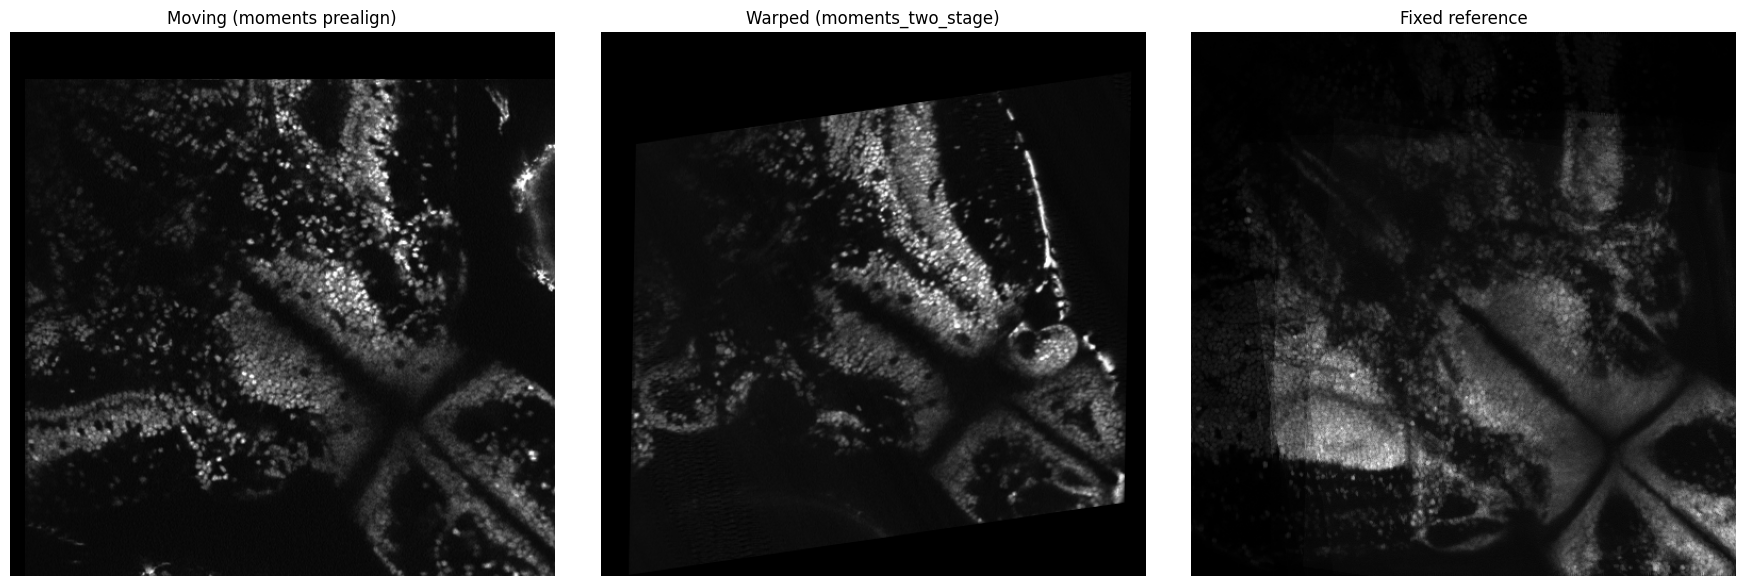

In [24]:
import matplotlib.pyplot as plt

def middle_slice(volume: np.ndarray) -> np.ndarray:
    if volume.ndim != 3:
        raise ValueError(f'Expected 3D volume, got shape {volume.shape}')
    return volume[volume.shape[0] // 2]

fixed_np = sitk.GetArrayFromImage(fixed_preprocessed_sitk)
moving_np = sitk.GetArrayFromImage(moving_preprocessed_sitk)

if not results:
    raise RuntimeError('No results available. Run the experiment cell before plotting.')

# Prefer the last experiment (typically the most refined).
selected_record = results[-1]
selected_name = selected_record['name']
warped_np = selected_record['warp'].squeeze().detach().cpu().numpy()

initial_stage_entry = next((stage for stage in selected_record['stages'] if stage.get('index') == 0), None)
final_stage_entry = max(selected_record['stages'], key=lambda stage: stage.get('index', -1))

def format_shift_and_sigma(translation, singular_values):
    if translation is None or singular_values is None:
        return 'Δ: (n/a)\nσ: (n/a)'
    translation = np.asarray(translation).astype(float).flatten()
    singular_values = np.asarray(singular_values).astype(float).flatten()
    shift_text = f"Δ: ({translation[0]:+.2f}, {translation[1]:+.2f}, {translation[2]:+.2f})"
    sigma_text = f"σ: ({singular_values[0]:.3f}, {singular_values[1]:.3f}, {singular_values[2]:.3f})"
    return f"{shift_text}\n{sigma_text}"

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(middle_slice(moving_np), cmap='gray')
axes[0].set_title('Moving (moments prealign)')
axes[0].axis('off')
axes[0].set_xlabel(
    format_shift_and_sigma(
        initial_stage_entry['summary']['translation'] if initial_stage_entry else None,
        initial_stage_entry['summary']['singular_values'] if initial_stage_entry else None,
    ),
    fontsize=11,
)

axes[1].imshow(middle_slice(warped_np), cmap='gray')
axes[1].set_title(f'Warped ({selected_name})')
axes[1].axis('off')
axes[1].set_xlabel(
    format_shift_and_sigma(
        final_stage_entry['summary']['translation'],
        final_stage_entry['summary']['singular_values'],
    ),
    fontsize=11,
)

axes[2].imshow(middle_slice(fixed_np), cmap='gray')
axes[2].set_title('Fixed reference')
axes[2].axis('off')
axes[2].set_xlabel('Δ: (0.00, 0.00, 0.00)\nσ: (1.000, 1.000, 1.000)', fontsize=11)

plt.tight_layout(pad=2.0)
plt.show()

Available experiments: ['moments_two_stage']


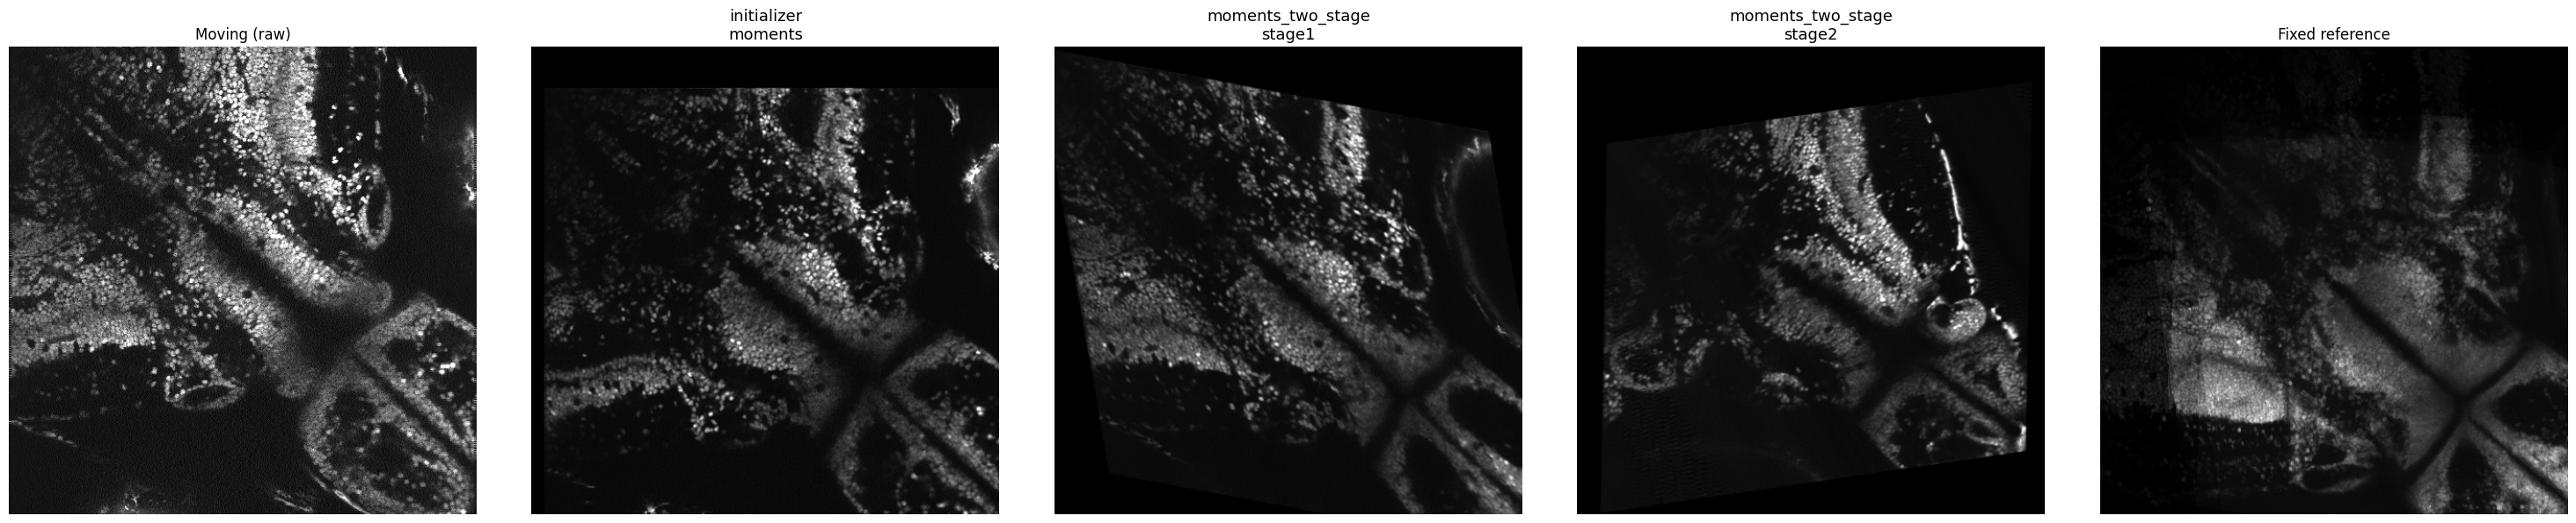

In [25]:
# Stage-by-stage visualization helper
import math

try:
    middle_slice
except NameError:
    def middle_slice(volume: np.ndarray) -> np.ndarray:
        if volume.ndim != 3:
            raise ValueError(f'Expected 3D volume, got shape {volume.shape}')
        return volume[volume.shape[0] // 2]

if not results:
    raise RuntimeError('Run the experiment cell before calling the stage visualization helper.')

available_experiments = [record['name'] for record in results]
print('Available experiments:', available_experiments)

# Customize these selections as needed
TARGET_EXPERIMENT = available_experiments[-1]
STAGE_SELECTION = None  # e.g. [0, 1, 3, 5] or None for all recorded stages

selected_record = next(record for record in results if record['name'] == TARGET_EXPERIMENT)
if not selected_record['stages']:
    raise RuntimeError('No per-stage outputs stored; ensure SAVE_STAGE_OUTPUTS = True and re-run experiments.')

selected_stages = selected_record['stages']
if STAGE_SELECTION is None:
    plot_stages = selected_stages
else:
    stage_map = {stage['index']: stage for stage in selected_stages}
    missing = [idx for idx in STAGE_SELECTION if idx not in stage_map]
    if missing:
        raise ValueError(f"Requested stage indices {missing} were not found in recorded stages.")
    plot_stages = [stage_map[idx] for idx in STAGE_SELECTION]

if any(stage.get('warp') is None for stage in plot_stages):
    raise RuntimeError('Stage warps were not captured. Set SAVE_STAGE_OUTPUTS = True before running experiments.')

raw_moving_np = sitk.GetArrayFromImage(moving_sitk).astype(np.float32)
num_panels = len(plot_stages) + 2  # raw moving + selected stages + fixed reference
fig, axes = plt.subplots(1, num_panels, figsize=(6 * num_panels, 6))

axes[0].imshow(middle_slice(raw_moving_np), cmap='gray')
axes[0].set_title('Moving (raw)')
axes[0].axis('off')
axes[0].set_xlabel('Δ: (n/a)\nσ: (n/a)', fontsize=11)

for ax, stage in zip(axes[1:-1], plot_stages):
    warp_tensor = stage['warp']
    stage_np = warp_tensor.squeeze().numpy()
    stage_idx = stage.get('index', '?')
    label_text = stage.get('label', f'Stage {stage_idx}')
    translation = np.asarray(stage['summary']['translation']).astype(float).flatten()
    singular_values = np.asarray(stage['summary']['singular_values']).astype(float).flatten()
    axes_title = label_text.replace(':', '\n')
    ax.imshow(middle_slice(stage_np), cmap='gray')
    ax.set_title(axes_title, fontsize=13)
    ax.axis('off')
    shift_text = f"Δ: ({translation[0]:+.2f}, {translation[1]:+.2f}, {translation[2]:+.2f})"
    singular_text = f"σ: ({singular_values[0]:.3f}, {singular_values[1]:.3f}, {singular_values[2]:.3f})"
    ax.set_xlabel(f"{shift_text}\n{singular_text}", fontsize=11)

axes[-1].imshow(middle_slice(fixed_np), cmap='gray')
axes[-1].set_title('Fixed reference')
axes[-1].axis('off')
axes[-1].set_xlabel('Δ: (0.00, 0.00, 0.00)\nσ: (1.000, 1.000, 1.000)', fontsize=11)

plt.tight_layout(pad=2.0)
plt.show()

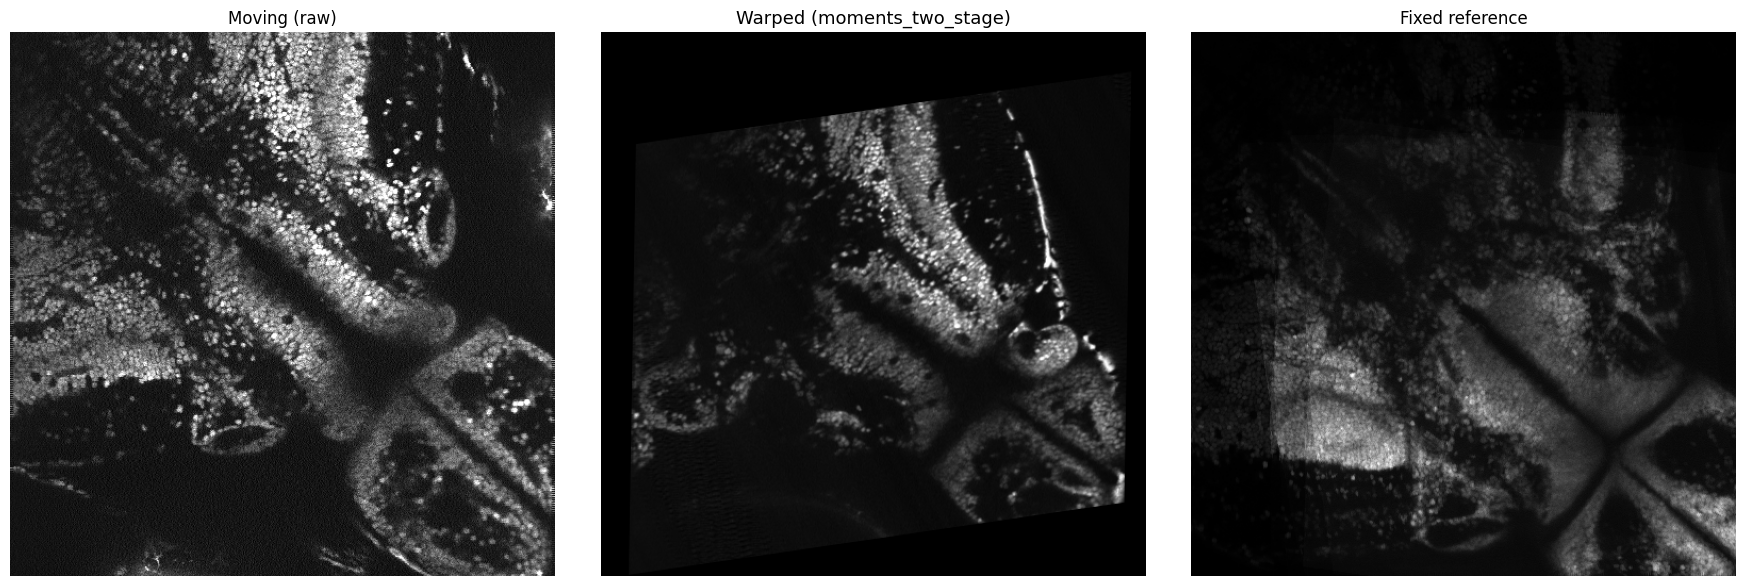

In [26]:
# Experiment comparison grid
if not results:
    raise RuntimeError('No experiment results available; run the experiment cell first.')

raw_moving_np = sitk.GetArrayFromImage(moving_sitk).astype(np.float32)
num_experiments = len(results)
fig, axes = plt.subplots(1, num_experiments + 2, figsize=(6 * (num_experiments + 2), 6))

def format_shift_and_sigma(translation, singular_values):
    translation = np.asarray(translation).astype(float).flatten()
    singular_values = np.asarray(singular_values).astype(float).flatten()
    shift_text = f"Δ: ({translation[0]:+.2f}, {translation[1]:+.2f}, {translation[2]:+.2f})"
    sigma_text = f"σ: ({singular_values[0]:.3f}, {singular_values[1]:.3f}, {singular_values[2]:.3f})"
    return f"{shift_text}\n{sigma_text}"

axes[0].imshow(middle_slice(raw_moving_np), cmap='gray')
axes[0].set_title('Moving (raw)')
axes[0].axis('off')
axes[0].set_xlabel('Δ: (n/a)\nσ: (n/a)', fontsize=11)

for ax, record in zip(axes[1:-1], results):
    exp_name = record['name']
    warp_tensor = record['warp']
    if warp_tensor is None:
        raise RuntimeError(f'Experiment {exp_name} is missing a final warp; rerun experiments with SAVE_STAGE_OUTPUTS = True.')
    warp_np = warp_tensor.squeeze().detach().cpu().numpy()
    final_stage = max(record['stages'], key=lambda stage: stage.get('index', -1))
    translation = final_stage['summary']['translation']
    singular_values = final_stage['summary']['singular_values']
    ax.imshow(middle_slice(warp_np), cmap='gray')
    ax.set_title(f'Warped ({exp_name})', fontsize=13)
    ax.axis('off')
    ax.set_xlabel(format_shift_and_sigma(translation, singular_values), fontsize=11)

axes[-1].imshow(middle_slice(fixed_np), cmap='gray')
axes[-1].set_title('Fixed reference')
axes[-1].axis('off')
axes[-1].set_xlabel('Δ: (0.00, 0.00, 0.00)\nσ: (1.000, 1.000, 1.000)', fontsize=11)

plt.tight_layout(pad=2.0)
plt.show()

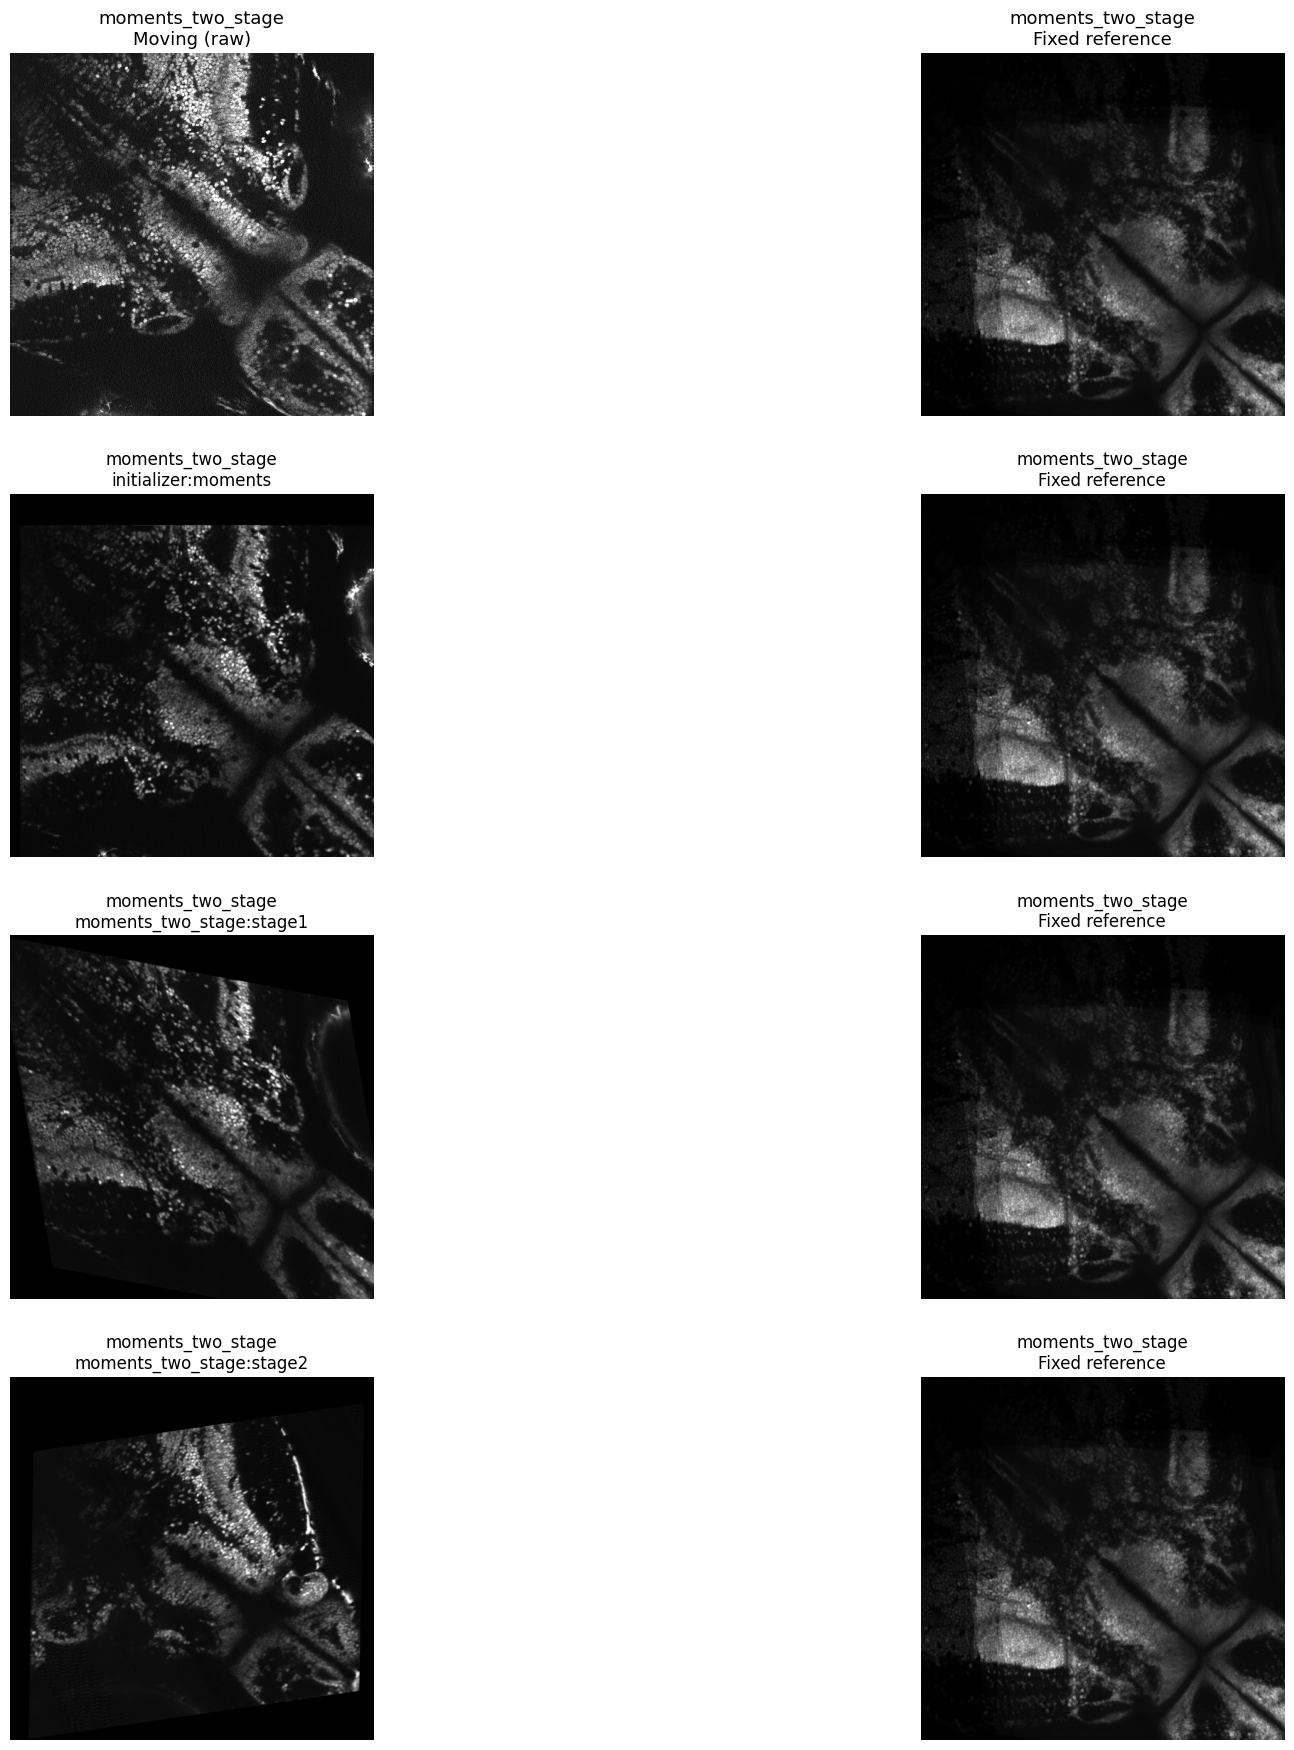

In [27]:
# Full stage comparison grid across experiments

if not results:
    raise RuntimeError('No experiment results available; run the experiment cell first.')

raw_moving_np = sitk.GetArrayFromImage(moving_sitk).astype(np.float32)
stage_indices = set()
experiment_stage_maps = {}
for record in results:
    stages_with_warp = [stage for stage in record['stages'] if stage.get('warp') is not None]
    if not stages_with_warp:
        raise RuntimeError(f"Experiment {record['name']} has no stage warps saved; rerun with SAVE_STAGE_OUTPUTS = True.")
    stage_map = {}
    for stage in stages_with_warp:
        stage_map[stage.get('index', len(stage_map))] = stage
        stage_indices.add(stage.get('index', len(stage_map)))
    experiment_stage_maps[record['name']] = stage_map

sorted_stage_indices = sorted(stage_indices)
num_experiments = len(results)
num_rows = len(sorted_stage_indices) + 1  # include raw row
num_columns = num_experiments * 2
fig_width = max(4.5 * num_columns, 24)
fig_height = max(4.5 * num_rows, 18)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(fig_width, fig_height), squeeze=False)

for exp_idx, record in enumerate(results):
    col_warp = exp_idx * 2
    col_fixed = col_warp + 1

    axes[0, col_warp].imshow(middle_slice(raw_moving_np), cmap='gray')
    axes[0, col_warp].set_title(f"{record['name']}\nMoving (raw)", fontsize=13)
    axes[0, col_warp].axis('off')
    axes[0, col_warp].set_xlabel('Δ: (n/a)\nσ: (n/a)', fontsize=10)

    axes[0, col_fixed].imshow(middle_slice(fixed_np), cmap='gray')
    axes[0, col_fixed].set_title(f"{record['name']}\nFixed reference", fontsize=13)
    axes[0, col_fixed].axis('off')
    axes[0, col_fixed].set_xlabel('Δ: (0.00, 0.00, 0.00)\nσ: (1.000, 1.000, 1.000)', fontsize=10)

for row_offset, stage_idx in enumerate(sorted_stage_indices, start=1):
    for exp_idx, record in enumerate(results):
        col_warp = exp_idx * 2
        col_fixed = col_warp + 1
        warp_ax = axes[row_offset, col_warp]
        fixed_ax = axes[row_offset, col_fixed]
        stage = experiment_stage_maps[record['name']].get(stage_idx)

        if stage is None:
            warp_ax.axis('off')
            warp_ax.set_title(f"{record['name']}\nStage {stage_idx} (missing)", fontsize=12)
            fixed_ax.axis('off')
            continue

        stage_np = stage['warp'].squeeze().numpy()
        label_text = stage.get('label', f'Stage {stage_idx}')
        translation = np.asarray(stage['summary']['translation']).astype(float).flatten()
        singular_values = np.asarray(stage['summary']['singular_values']).astype(float).flatten()
        warp_ax.imshow(middle_slice(stage_np), cmap='gray')
        warp_ax.set_title(f"{record['name']}\n{label_text}", fontsize=12)
        warp_ax.axis('off')
        shift_text = f"Δ: ({translation[0]:+.2f}, {translation[1]:+.2f}, {translation[2]:+.2f})"
        sigma_text = f"σ: ({singular_values[0]:.3f}, {singular_values[1]:.3f}, {singular_values[2]:.3f})"
        warp_ax.set_xlabel(f"{shift_text}\n{sigma_text}", fontsize=10)

        fixed_ax.imshow(middle_slice(fixed_np), cmap='gray')
        fixed_ax.set_title(f"{record['name']}\nFixed reference", fontsize=12)
        fixed_ax.axis('off')
        fixed_ax.set_xlabel('Δ: (0.00, 0.00, 0.00)\nσ: (1.000, 1.000, 1.000)', fontsize=10)

plt.tight_layout(pad=2.5)
plt.show()